# Examples on Paths

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [48]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

## Loading the Data

In this notebook we examine data from the https://www.timeseriesclassification.com/dataset.php website for benchmarking time series data.

In [49]:
import sktime
from sktime.datasets import load_from_tsfile

In [90]:
#DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), "./path-data/")

train_x, train_y = load_from_tsfile("path-data/Univariate_ts/BirdChicken/BirdChicken_TRAIN.ts",  return_data_type="numpy2d")

test_x, test_y = load_from_tsfile("path-data/Univariate_ts/BirdChicken/BirdChicken_TEST.ts", return_data_type="numpy2d")

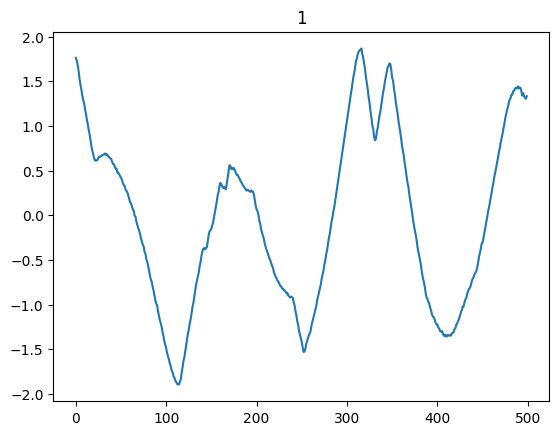

In [92]:
# plot the first time series
plt.plot(train_x[0, :500])
plt.title(train_y[0])
plt.show()


## Converting into the right format

In [93]:
# make a delay embedding of the path
def delay_embedding(path, delay):
    return torch.cat([path[i:i-delay].reshape(1,-1) for i in range(delay)], dim=0).T

In [94]:
train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)

In [95]:
# delay embedd all the training paths with a delay of 10
train_x = [delay_embedding(train_x[i], 10) for i in range(len(train_x))]
train_x = torch.stack(train_x)

train_x.shape

torch.Size([20, 502, 10])

In [96]:
# delay embedd all the test paths with a delay of 10
test_x = [delay_embedding(test_x[i], 10) for i in range(len(test_x))]
test_x = torch.stack(test_x)

test_x.shape

torch.Size([20, 502, 10])

In [97]:
# convert the elements of train_y to int
train_y = [int(train_y[i])-1 for i in range(len(train_y))] # we subtract 1 because the labels are 1 and 2 and we want them to be 0 and 1

# one hot encode integer labels
train_y = torch.tensor(train_y)
train_y = torch.nn.functional.one_hot(train_y)

In [98]:
# convert the elements of train_y to int
test_y = [int(test_y[i])-1 for i in range(len(test_y))] # we subtract 1 because the labels are 1 and 2 and we want them to be 0 and 1

# one hot encode integer labels
test_y = torch.tensor(test_y)
test_y = torch.nn.functional.one_hot(test_y)

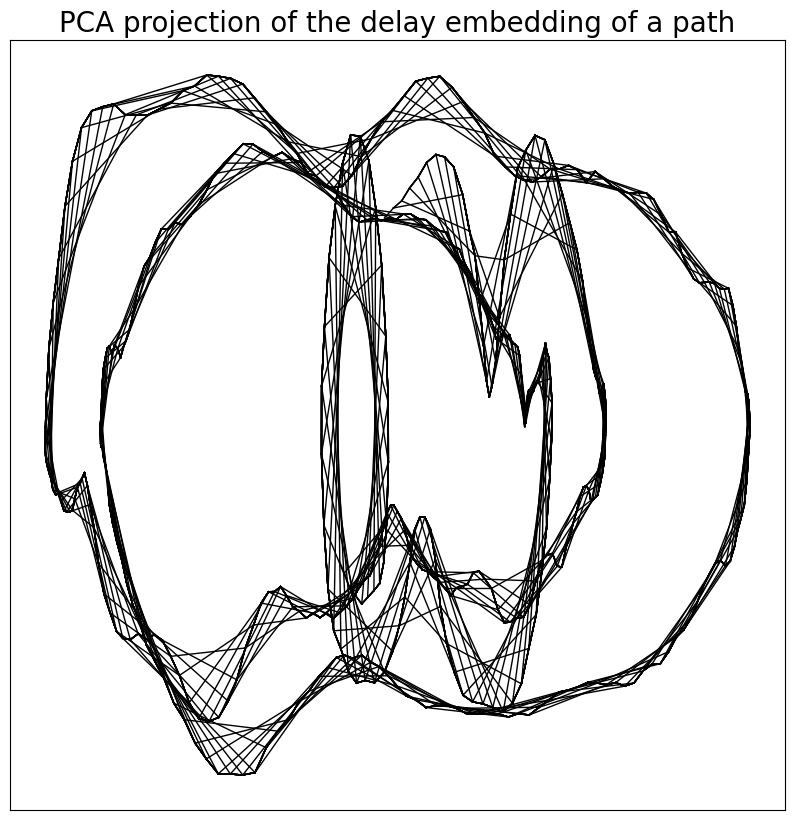

In [73]:
import sklearn as sk
import sklearn.decomposition as skdecomposition

## plot a set of points and connect consecutive points with lines
def plot_points(points, ax, color = 'black', alpha = 1, linewidth = 1):

    n = points.shape[0]

    for i in range(n-1):
        ax.plot(points[i:i+2,0],points[i:i+2,1], color = color, alpha = alpha, linewidth = linewidth)

    return ax

# plot the delay embedding of the path using the above function
fig, ax = plt.subplots(1,1, figsize = (10,10))


# plot the PCA projection of the delay embedding
sckit_pca = skdecomposition.PCA(n_components=2)
pca = sckit_pca.fit_transform(delay_embedding(train_x[1], 10))

ax = plot_points(pca, ax, alpha = 1, linewidth = 1)

# add a title
ax.set_title("PCA projection of the delay embedding of a path", fontsize = 20)

# remove the ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()



## Simple Example

## Integrating Paths Agains Vector Fields


We first need a few functions for doing efficient path integration in this setting.

In [24]:
# a function for turning a path into a chain
def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain



In [25]:
# a function for turning a chain into a cochain data matrix
def gen_CDM2(vf,chain, d = 5):
    """
    A function for generating a cochain data matrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    \chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features / n)

    # apply the vector field to the discretized chain
    out = vf(chain).reshape((r,d,n,c))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

### Running the model

First up, we initialise the vector field as a simple MLP with ReLU activations.

In [81]:
c = 2 # number of features/columns in cochain data matrix - in this example, this is the number of classes
n = 10

vf = nn.Sequential(
    nn.Linear(n, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, n*c)
)

In [77]:
import cochainlearning as cl

### Training and Gradient Descent

Now we begin the training phase. We use stand SGD with a learning rate of 0.01 and a momentum of 0.9. We train for 50 epoches and employ a Cross-Entropy loss.

In [82]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()

paths = train_x
labels = train_y


In [83]:
epochs = 500

batch_size = len(paths)

losses = torch.zeros((batch_size,epochs))

for j in range(epochs):

    # make a random choice of size batch_size
    idx = np.random.choice(len(paths), size=batch_size, replace=False)

    batch_paths = [paths[i] for i in idx]
    batch_labels = labels[idx]

        
    for i in range(batch_size):

        p = batch_paths[i]
        l = batch_labels[i]

        p = cl.path_to_chain(p)
        
        X = cl.gen_CDM(vf, p, d = 5)

        X = torch.sum(X, axis = 0)


        sm = torch.nn.functional.softmax(X)


        loss = criterion(sm,l.float())

        losses[i,j] = loss.detach()

        
        loss.backward()

        # for some reason it works better doing the backprop/gradient step after each path

        optimizer.step()


        optimizer.zero_grad()


    # clear print statement from previous iteration
    # clear_output(wait=True)
    
    print("Epoch = ", j, "Loss = ", torch.sum(losses[:,j])/batch_size)




/Users/kelly/Documents/phd_code/cochain_representation_learning/cochainlearning.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chain[:,1,:] = torch.tensor(p[1:,:])
/Users/kelly/Documents/phd_code/cochain_representation_learning/cochainlearning.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chain[:,0,:] = torch.tensor(p[0:-1,:])
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_5111/951289183.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


Epoch =  0 Loss =  tensor(0.7160)
Epoch =  1 Loss =  tensor(0.7027)
Epoch =  2 Loss =  tensor(0.6926)
Epoch =  3 Loss =  tensor(0.6857)
Epoch =  4 Loss =  tensor(0.6809)
Epoch =  5 Loss =  tensor(0.6766)
Epoch =  6 Loss =  tensor(0.6744)
Epoch =  7 Loss =  tensor(0.6729)
Epoch =  8 Loss =  tensor(0.6716)
Epoch =  9 Loss =  tensor(0.6707)
Epoch =  10 Loss =  tensor(0.6696)
Epoch =  11 Loss =  tensor(0.6688)
Epoch =  12 Loss =  tensor(0.6678)
Epoch =  13 Loss =  tensor(0.6673)
Epoch =  14 Loss =  tensor(0.6666)
Epoch =  15 Loss =  tensor(0.6659)
Epoch =  16 Loss =  tensor(0.6653)
Epoch =  17 Loss =  tensor(0.6646)
Epoch =  18 Loss =  tensor(0.6639)
Epoch =  19 Loss =  tensor(0.6633)
Epoch =  20 Loss =  tensor(0.6628)
Epoch =  21 Loss =  tensor(0.6621)
Epoch =  22 Loss =  tensor(0.6617)
Epoch =  23 Loss =  tensor(0.6611)
Epoch =  24 Loss =  tensor(0.6606)
Epoch =  25 Loss =  tensor(0.6600)
Epoch =  26 Loss =  tensor(0.6595)
Epoch =  27 Loss =  tensor(0.6590)
Epoch =  28 Loss =  tensor(0.6

As we see below, the loss behaves very nicely with respect to the epochs. 

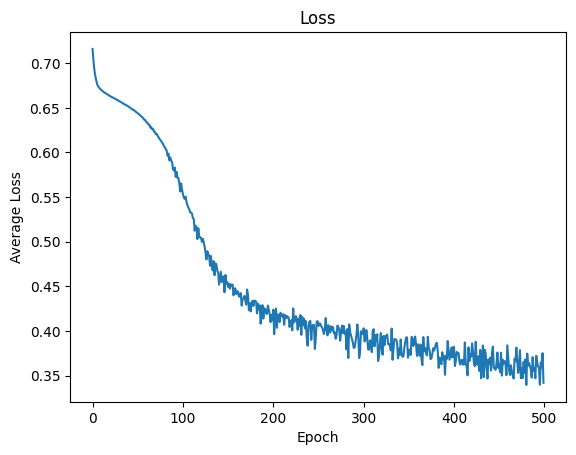

In [84]:
# plot the loss
L = torch.sum(losses,axis=0)/batch_size
plt.plot(L)
plt.title('Loss')

# add x and y labels
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.show()

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_5111/2233580776.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 100 training paths: 100 %


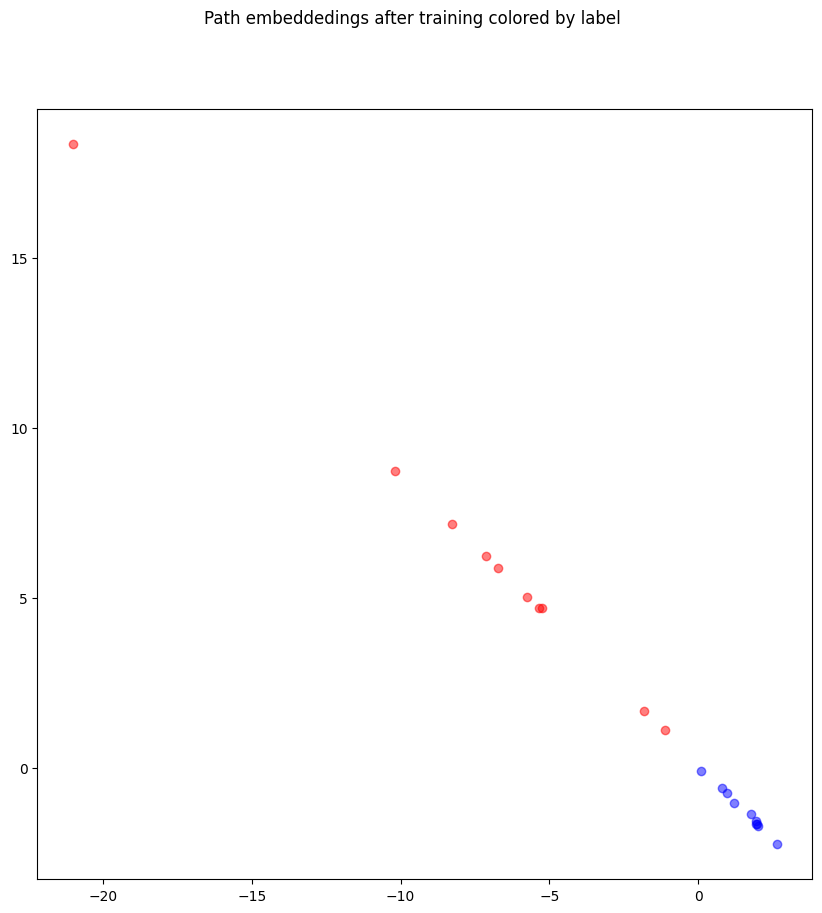

In [103]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = paths[i]
        l = labels[i]
        
        p = cl.path_to_chain(p)
        X = cl.gen_CDM(vf, p)
        
        X = torch.sum(X, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'blue', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'red', alpha = 0.5)


print('Accuracy of the network on the 100 training paths: %d %%' % (100 * correct / total))

# add a title to the figure
fig.suptitle('Path embeddedings after training colored by label')



plt.show()

## Evaluation

In [ ]:
test_paths = test_x
test_labels = test_y

/Users/kelly/Documents/phd_code/cochain_representation_learning/cochainlearning.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chain[:,1,:] = torch.tensor(p[1:,:])
/Users/kelly/Documents/phd_code/cochain_representation_learning/cochainlearning.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chain[:,0,:] = torch.tensor(p[0:-1,:])
/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_5111/3076152389.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(X))


Accuracy of the network on the 100 training paths: 85 %


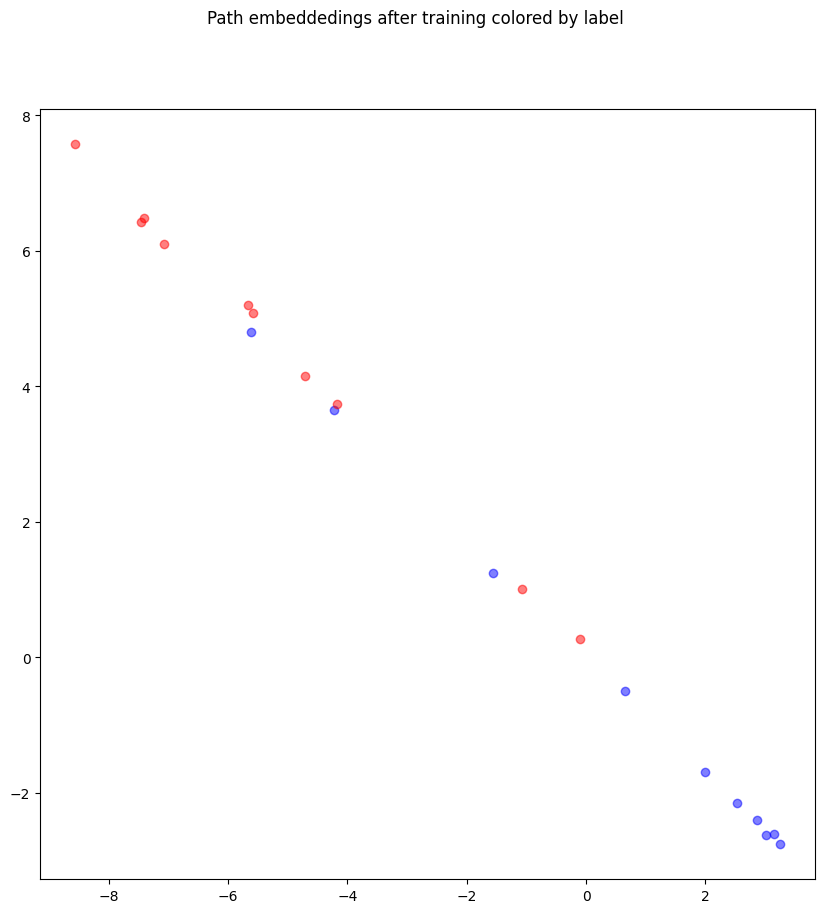

In [102]:
# make a 3d scatter plot of vf evaluated on the set of paths, colored by labels
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

# evaluate the accuracy of the classifier on the training data
correct = 0
total = 0

for i in range(len(paths)):
        
        p = test_paths[i]
        l = test_labels[i]
        
        p = cl.path_to_chain(p)
        X = cl.gen_CDM(vf, p)
        
        X = torch.sum(X, dim = 0)

        lb = torch.argmax(l)

        pred = torch.argmax(torch.nn.functional.softmax(X))

        if pred == torch.argmax(l):
                correct += 1
        total += 1
        
        
        if lb == 0:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'blue', alpha = 0.5)
        elif lb == 1:
            ax.scatter(X[0].detach().numpy(), X[1].detach().numpy(), color = 'red', alpha = 0.5)


print('Accuracy of the network on the 100 training paths: %d %%' % (100 * correct / total))

# add a title to the figure
fig.suptitle('Path embeddedings after training colored by label')

plt.show()